# Ch8. 案例分析

本书已经介绍了几种不同的特征学习算法，也利用了很多不同的数据集。本章会通过一些案例，帮助你加深对书中各个主题的理解。我们会从头到尾完成对两个案例的研究，以进一步了解特征工程如何在现实应用中帮助我们创建机器学习流水线。对于每个案例，我们都会从如下几方面介绍：

- 要实现的应用；
- 使用的数据；
- 探索性数据分析；
- 机器学习流水线和指标。

要研究的案例主题如下：

- 面部识别；
- 预测酒店评论数据。

我们开始吧！

## 8.1 案例1：面部识别 

In [1]:
# 特征提取模块
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 特征缩放模块
from sklearn.preprocessing import StandardScaler

# 标准 Python 模块 
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# scikit-learn 的特征选择模块
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# 指标
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 机器学习模块
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
# !git clone https://github.com/ashishpatel26/Facial-Expression-Recognization-using-JAFFE.git

In [3]:
data_path = 'C:/pwork/Facial-Expression-Recognization-using-JAFFE/jaffe/'
data_dir_list = os.listdir(data_path)
data_dir_list

['ANGRY', 'DISGUST', 'FEAR', 'HAPPY', 'NEUTRAL', 'SAD', 'SURPRISE']

In [4]:
img_rows = 256
img_cols = 256
num_channel = 1

num_epoch = 10
img_data_list = []
labels = []

for dataset in data_dir_list:
    img_list = os.listdir(data_path + dataset)
    print('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img = cv2.imread(data_path + dataset + '/' + img)
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize = cv2.resize(input_img, (128, 128))
        img_data_list.append(input_img_resize)
        labels.append(dataset)
    
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data / 255
img_data.shape

Loaded the images of dataset-ANGRY

Loaded the images of dataset-DISGUST

Loaded the images of dataset-FEAR

Loaded the images of dataset-HAPPY

Loaded the images of dataset-NEUTRAL

Loaded the images of dataset-SAD

Loaded the images of dataset-SURPRISE



(213, 128, 128)

In [5]:
n_samples, h, w = img_data.shape
n_samples, h, w

(213, 128, 128)

In [6]:
# 直接使用 不管相对像素位置 
X = img_data
y = np.array(labels)

In [7]:
XX = img_data.reshape((213, -1))
XX.shape

(213, 16384)

Text(0.5, 1.0, 'ANGRY')

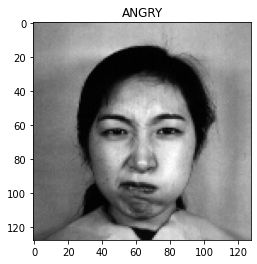

In [8]:
# 绘制其中一张脸
plt.imshow(XX[0].reshape(h, w), cmap=plt.cm.gray)
plt.title(y[0])

Text(0.5, 1.0, 'ANGRY')

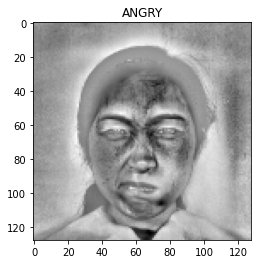

In [9]:
# 我们在缩放后重新绘制一次图像
plt.imshow(StandardScaler().fit_transform(XX)[0].reshape(h, w), cmap=plt.cm.gray)
plt.title(y[0])

In [10]:
# 预测表情
n_classes = len(data_dir_list)
n_features = XX.shape[1]
features_name = data_dir_list


print("Total dataset size:") 
print("n_samples: %d" % n_samples) 
print("n_features: %d" % n_features) 
print("n_classes: %d" % n_classes)
print(f"features name: {features_name}")

Total dataset size:
n_samples: 213
n_features: 16384
n_classes: 7
features name: ['ANGRY', 'DISGUST', 'FEAR', 'HAPPY', 'NEUTRAL', 'SAD', 'SURPRISE']


In [11]:
# 把数据分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.25, random_state=1)

In [12]:
y_train[:10]

array(['SAD', 'FEAR', 'SURPRISE', 'FEAR', 'SURPRISE', 'SURPRISE', 'HAPPY',
       'NEUTRAL', 'HAPPY', 'HAPPY'], dtype='<U8')

In [13]:
# PCA 实例化
pca = PCA(n_components=50, whiten=True)
# 创建流水线，扩充数据，然后应用 PCA 
preprocessing = Pipeline([
    ('scale', StandardScaler()), ('pca', pca)
])

print("Extracting the top %d eigenfaces from %d faces" % (50, X_train.shape[0]))

# 在训练集上拟合流水线 
preprocessing.fit(XX)

Extracting the top 50 eigenfaces from 159 faces


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True))],
         verbose=False)

In [14]:
# 从流水线上取 PCA 
extracted_pca = preprocessing.steps[1][1]

In [15]:
preprocessing.steps[1][1]

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

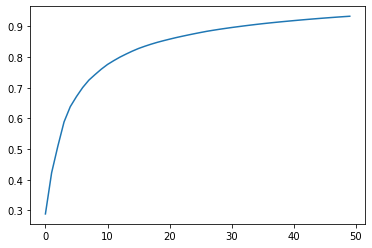

In [16]:
plt.plot(np.cumsum(extracted_pca.explained_variance_ratio_))

In [17]:
comp = extracted_pca.components_
image_shape = (h, w)

def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i+1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

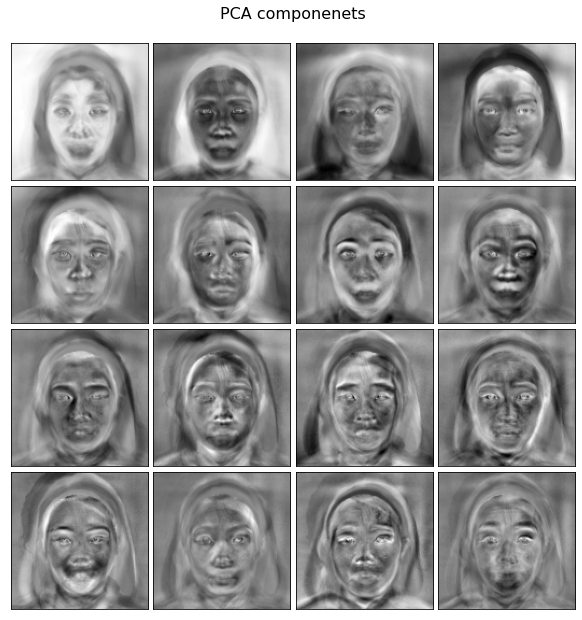

In [18]:
plot_gallery('PCA componenets', comp[:16], 4,4)

In [19]:
import itertools
def plot_confusion_matrix(cm,classes, 
                          normalize=False, 
                          title='Confusionmatrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

0.7777777777777778 Accuracy score for best estimator
----------------------------------------
None
----------------------------------------
685.2 seconds to grid search and predict the test set


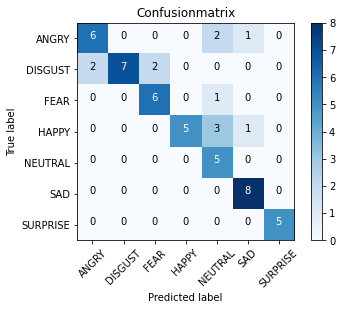

In [20]:
# 不用 PCA，看看差异
t0 = time()
logreg = LogisticRegression(max_iter=10000)

params_grid = {
    'C': [1e-2, 1e-1, 1e-0, 1e1, 1e2]
}
clf = GridSearchCV(logreg, params_grid)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# 用测试集进行预测 
y_pred = best_clf.predict(X_test)
print(accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print('--'*20)
print(plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=features_name), features_name))
print('--'*20)
print(round((time() - t0), 1), "seconds to grid search and predict the test set") 

In [21]:
X_train.shape

(159, 16384)

0.6666666666666666 Accuracy score for best estimator
----------------------------------------
              precision    recall  f1-score   support

       ANGRY       0.50      0.44      0.47         9
     DISGUST       0.75      0.55      0.63        11
        FEAR       0.67      0.86      0.75         7
       HAPPY       1.00      0.44      0.62         9
     NEUTRAL       0.45      1.00      0.62         5
         SAD       0.67      0.75      0.71         8
    SURPRISE       1.00      1.00      1.00         5

    accuracy                           0.67        54
   macro avg       0.72      0.72      0.69        54
weighted avg       0.72      0.67      0.66        54

----------------------------------------
None
----------------------------------------
13.6 seconds to grid search and predict the test set


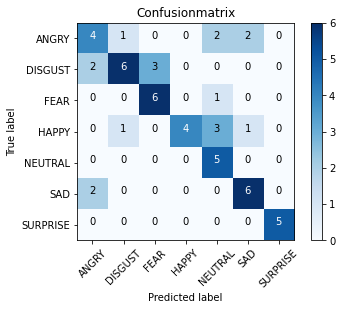

In [22]:
# 用 PCA 
t0 = time()
face_pipeline = Pipeline(steps=[('PCA', PCA(n_components=50)), ('logistic', logreg)])
pipe_param_grid = {'logistic__C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
clf = GridSearchCV(face_pipeline, pipe_param_grid)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

y_pred = best_clf.predict(X_test) 
 
print(accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print('--'*20)
print(classification_report(y_test, y_pred))
print('--'*20)
print(plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=features_name), features_name))
print('--'*20)
print(round((time() - t0), 1), "seconds to grid search and predict the test set") 

In [23]:
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0.)# 如果报错，结果是0
    grid.fit(X, y)
    # 经典的性能指标
    print("Best Accuracy: {}".format(grid.best_score_))
    # 得到最佳准确率的最佳参数
    print("Best Parameters: {}".format(grid.best_params_)) # 拟合的平均时间(秒)
    print("Average Time to Fit (s):{}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))) # 预测的平均时间(秒)
    # 从该指标可以看出模型在真实世界的性能
    print("Average Time to Score (s):{}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

In [24]:
face_params = {'logistic__C':[1e-2, 1e-1, 1e0, 1e1, 1e2],
               'preprocessing__pca__n_components':[100, 150, 200, 250, 300],
               'preprocessing__pca__whiten':[True, False],
               'preprocessing__lda__n_components':range(1, 7)
               # [1, 2, 3, 4, 5, 6] recall the max allowed is n_classes-1
}
pca = PCA()
lda = LinearDiscriminantAnalysis()

 
preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca), ('lda', lda)]) 
 
logreg = LogisticRegression() 
face_pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('logistic', logreg)])

In [25]:
get_best_model_and_accuracy(face_pipeline, face_params, XX, y)

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\lo

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs fa

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\lo

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\lo

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=171 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: n_components=250 must be between 0 and min(n_samples, n_features)=170 with svd_solver='full'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\13631\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estim

Best Accuracy: 0.6580287929125139
Best Parameters: {'logistic__C': 0.1, 'preprocessing__lda__n_components': 6, 'preprocessing__pca__n_components': 100, 'preprocessing__pca__whiten': True}
Average Time to Fit (s):0.578
Average Time to Score (s):0.01
